In [1]:
import pickle
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sksurv.preprocessing import OneHotEncoder as SurvOneHotEncoder
from sksurv.util import Surv

from sksurv.column import encode_categorical
from sksurv.column import standardize

from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
    brier_score
)

# Train data
# pickle_file = 'data/DATA_COXNET_DECEASED.pickle'
# with open(pickle_file, 'rb') as f:
#     X, y = pickle.load(f)
pd.set_option('display.max_rows', 500)

In [2]:
# pickle_file = 'data/COX_DATA_FULL_DECEASED_EXPERIMENTAL.pkl'
# pickle_file = 'data/DATA_DECEASED.pkl'
pickle_file = 'data/DATA_DECEASED_ex.pkl'

with open(pickle_file, 'rb') as f:
    dataset = pickle.load(f)

In [3]:
dataset.to_csv('data/DATA_DECEASED_ex.csv', index=False)

In [4]:
numeric_features = [
    "AGE",
    "BMI_CALC",
    "AGE_DON",
    "CREAT_TRR",
    "NPKID",
    "COLD_ISCH_KI",
    "DIALYSIS_TIME",
    "KDPI",
]
categorical_features = [
    "ON_DIALYSIS",
    "PRE_TX_TXFUS",
    "GENDER",
    "ETHCAT",
    "DIABETES_DON",
    "DIAB",
    "HCV_SEROSTATUS",
]


In [5]:
dataset[numeric_features].dtypes

AGE              float64
BMI_CALC         float64
AGE_DON          float64
CREAT_TRR        float64
NPKID            float64
COLD_ISCH_KI     float64
DIALYSIS_TIME    float64
KDPI             float64
dtype: object

In [6]:
dataset[numeric_features].quantile([0.01, 0.99]) # for synthetic data generation

,AGE,BMI_CALC,AGE_DON,CREAT_TRR,NPKID,COLD_ISCH_KI,DIALYSIS_TIME,KDPI
0.01,20.0,17.5,1.0,1.8,0.0,3.1235,0.00,1.0
0.99,76.0,41.6,70.0,18.5,1.0,45.0000,5037.65,97.0


In [7]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformations for all features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Set up the final pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Apply preprocessing to X
X = pipeline.fit_transform(dataset[categorical_features + numeric_features ])

# categorical_x = encode_categorical(dataset[categorical_features])
# numerical_x = standardize(dataset[numeric_features])
# X = pd.concat([numerical_x, categorical_x], axis=1)

survival_time = dataset["PTIME"].astype(np.float64)
event = dataset["PSTATUS"].astype(float).astype(bool)

y = Surv.from_arrays(event, survival_time, "Status", "Days")

with open('pickle/trained_pipeline.pkl', 'wb') as file:
    pickle.dump(pipeline, file)

In [8]:
from sksurv.column import encode_categorical
from sksurv.column import standardize
from sksurv.util import Surv

from surv_data_pipeline.columns import COLUMNS
from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y["Status"], random_state=42)


In [9]:
from sksurv.linear_model import CoxnetSurvivalAnalysis

cox = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01, max_iter=1000)
cox.fit(X_train, y_train)

estimated_alphas = cox.alphas_
l1_ratios = [0.8]

In [10]:
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)

def evaluate_model_uno_c(model, test_X, test_y, train_y, times):
    pred = model.predict(test_X)
    uno_concordance = concordance_index_ipcw(train_y, test_y, pred, tau=times[-1])
    return uno_concordance

def evaluate_model(model, test_X, test_y, train_y, times):
    pred = model.predict(test_X)
    surv_fn = model.predict_survival_function(test_X, return_array=False)
    surv_prob = np.row_stack([fn(times) for fn in surv_fn])

    uno_concordance = concordance_index_ipcw(train_y, test_y, pred, tau=times[-1])
    ibs = integrated_brier_score(train_y, test_y, surv_prob, times)
    auc, mean_auc = cumulative_dynamic_auc(train_y, test_y, pred, times)

    print(f"Concordance Uno: {round(uno_concordance[0], 3)}")
    print(f"IBS: {round(ibs, 3)}")
    print(f"Mean AUC: {round(mean_auc,3)}")

    return uno_concordance, ibs, mean_auc

In [11]:
from tqdm import tqdm
import numpy as np

best_params = None
highest_cindex=0

lower, upper = np.percentile(y["Days"], [10, 90])
times = np.arange(lower, upper + 1)

cox_grid=CoxnetSurvivalAnalysis()

pbar = tqdm(total = len(estimated_alphas)*len(l1_ratios), desc='Hyperparameter Tuning')

for ratio in l1_ratios:
    for alpha in estimated_alphas:
        cox_grid.set_params(l1_ratio=ratio, alphas=[alpha])

        cox_grid.fit(X_train, y_train)
        uno_score = evaluate_model_uno_c(cox_grid, X_test, y_test, y_train, times)

        uno = float(uno_score[0])
        if uno > highest_cindex:
            highest_cindex = uno
            best_params = (ratio, alpha)
            best_rsf_model = cox_grid

        # Update the progress bar
        pbar.update()

Hyperparameter Tuning:   0%|          | 0/100 [00:00<?, ?it/s]

Hyperparameter Tuning: 100%|██████████| 100/100 [03:10<00:00,  1.95s/it]

In [12]:
highest_cindex

0.6945789845558723

In [13]:
best_params

(0.8, 0.002711947206189305)

In [14]:
coxnet_pred = CoxnetSurvivalAnalysis(l1_ratio=best_params[0],alphas=[best_params[1]], fit_baseline_model=True)
coxnet_pred.fit(X_train, y_train)

CoxnetSurvivalAnalysis(alphas=[0.002711947206189305], fit_baseline_model=True,
                       l1_ratio=0.8)

In [15]:
lower, upper = np.percentile(y["Days"], [10, 90])
times = np.arange(lower, upper + 1)

evaluate_model(coxnet_pred, X_test, y_test, y_train, times)

Concordance Uno: 0.695
IBS: 0.163
Mean AUC: 0.729


((0.6945789845558723, 102863351, 45651937, 2, 22189),
 0.16348991091329643,
 0.72892212275488)

In [16]:
k

NameError: name 'k' is not defined

0.689 without HLA. without scikit pipeline
0.688 with HLA with scikit pipeline

In [ ]:
import pickle

# with open('pickle/COXNET_DECEASED_MODEL.pickle', 'wb') as f:
#     pickle.dump(coxnet_pred, f)

In [ ]:
prediction = coxnet_pred.predict_survival_function(X_test)
prediction.shape

(23508,)

# Model Evaluation

In [24]:
from surv_data_pipeline.estimator_evaluation import SurvivalEstimatorEvaluation
import matplotlib.pyplot as plt

# SurvivalEstimatorEvaluation.plot_time_dependent_auc(coxnet_pred, X_test, y_test, times)
def plot_time_dependent_auc(model, x_test, y_test, y_train, name=None):
    lower, upper = np.percentile(y_train["Days"], [10, 90])
    times = np.arange(lower, upper + 1)
    print("predicting....")
    cph_risk_scores = model.predict(x_test)
    print("calculating auc...")
    auc, mean_auc = cumulative_dynamic_auc(y_train, y_test, cph_risk_scores, times)
    print("plotting inside...")
    plt.plot(times, auc, marker=",")
    plt.axhline(mean_auc, linestyle="--")
    # plt.text(5, 0, "{model}", fontsize=12)
    plt.xlabel("days")
    plt.ylabel("time-dependent AUC")
    plt.grid(True)
    if name is not None:
        plt.savefig(f"/mnt/lustre/helios-home/stadnkyr/AUC_results/{name}_MAUC_{mean_auc}.png")
    plt.show()

predicting....
calculating auc...
plotting inside...


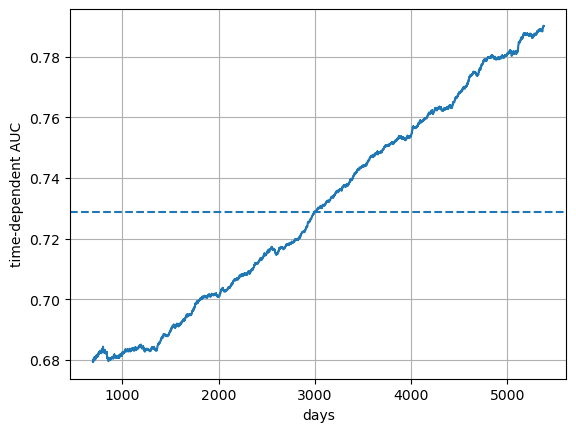

In [25]:
plot_time_dependent_auc(coxnet_pred, X_test, y_test, y_train)

In [17]:
surv_fn = coxnet_pred.predict_survival_function(X_test, return_array=False)

surv_prob = np.row_stack([fn(times) for fn in surv_fn])

bs = brier_score(y_train, y_test, surv_prob, times)
ibs = integrated_brier_score(y_train, y_test, surv_prob, times)#times)
print('Integrated Brier Score:', ibs)

Integrated Brier Score: 0.16348991091329643


Integrated Brier Score: 0.16520201404135063

Text(0, 0.5, 'time-dependent Brier Score')

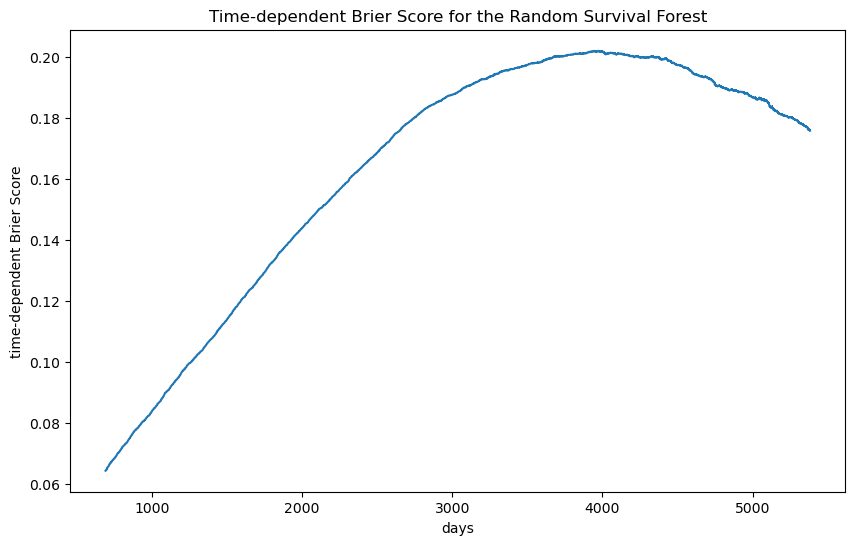

In [20]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10,6))
plt.plot(bs[0], bs[1], marker=",")
# plt.axhline(ibs, linestyle="--")
# plt.text(5, 0, "{model}", fontsize=12)
plt.title("Time-dependent Brier Score for the Random Survival Forest")
plt.xlabel("days")
plt.ylabel("time-dependent Brier Score")

In [22]:
import pickle

with open('pickle/brier/BS_COXNET_DECEASED_FINAL.pickle', 'wb') as f:
    pickle.dump(bs, f)


In [27]:
lower, upper = np.percentile(y_train["Days"], [10, 90])
times = np.arange(lower, upper + 1)
cph_risk_scores = coxnet_pred.predict(X_test)
auc, mean_auc = cumulative_dynamic_auc(y_train, y_test, cph_risk_scores, times)


In [29]:
import pickle

with open('pickle/AUC/AUC_COXNET_DECEASED_FINAL.pickle', 'wb') as f:
    pickle.dump((times, auc, mean_auc), f)

# Feature importance

In [ ]:
from sklearn.inspection import permutation_importance


# result = permutation_importance(coxnet_pred, X_test, y_test, n_repeats=10, random_state=0, n_jobs=1)

In [ ]:
pd.set_option('display.max_rows', 500)

columns = numeric_features + categorical_features

importances_df = pd.DataFrame(result.importances_mean, index=X.columns)
importances_df.columns = ['Importance']
importances_df.sort_values(by='Importance', ascending=False, inplace=True)

# Print out feature importances
importances_df

NameError: name 'result' is not defined